In [2]:
##### Config
from pyspark import SparkConf, SparkContext, HiveContext
import re
import numpy as np
import pandas as pd
import datetime

hive_config_query = '''
set hive.vectorized.execution.enabled=true;
set hive.vectorized.execution.reduce.enabled = true;
set mapreduce.map.memory.mb=4096;
set mapreduce.map.child.java.opts=-Xmx4g;
set mapreduce.task.io.sort.mb=1024;
set mapreduce.reduce.child.java.opts=-Xmx4g;
set mapreduce.reduce.memory.mb=7000;
set mapreduce.reduce.shuffle.input.buffer.percent=0.5;
set mapreduce.input.fileinputformat.split.minsize=536870912;
set mapreduce.input.fileinputformat.split.maxsize=1073741824;
set hive.optimize.ppd=true;
set hive.merge.smallfiles.avgsize=536870912;
set hive.merge.mapredfiles=true;
set hive.merge.mapfiles=true;
set hive.hadoop.supports.splittable.combineinputformat=true;
set hive.exec.reducers.bytes.per.reducer=536870912;
set hive.exec.parallel=true;
set hive.exec.max.created.files=10000000;
set hive.exec.compress.output=true;
set hive.exec.dynamic.partition.mode=nonstrict;
set hive.exec.max.dynamic.partitions=1000000;
set hive.exec.max.dynamic.partitions.pernode=100000;
set io.seqfile.compression.type=BLOCK;
set mapreduce.map.failures.maxpercent=5;
'''
try:
    sc.stop()
except:
    pass
conf = (SparkConf()
        .set("spark.executor.instances", 2)
        .set("spark.driver.maxResultSize", "8g")
        .set('spark.driver.memory','8g')
        .set("spark.executor.memory", '2g')
        .set("spark.yarn.executor.memoryOverhead", 1048)
       )
sc = SparkContext(conf=conf)
hc = HiveContext(sc)

for q in hive_config_query.split(';'):
    try:
        hc.sql(q)
    except:
        pass

In [3]:
 %matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Подготовка данных

In [4]:
SAS_Query = '''

%mAssignHadooplibs;

proc sql;

create table hd_ccall.cold_liru_results as 
select
  put(datepart(create_dt),YYMMDD10.) as ymd,
  b.phone_mobile,
  b.utm_campaign,
  b.hl_rk,  
  case when status = 'В работе' then 1 else 0 end as in_work,
  case when a.financial_application_rk is not Null then 1 else 0 end as full_app,
  case when a.decision_dt is not Null then 1 else 0 end as considered,
  case when a.decision_approve_dt is not Null then 1 else 0 end as approve,
  case when a.utilization_dt is not Null then 1 else 0 end as utilization
  
from emart.short_applications_current b 
  left join emart.financial_account_application a on b.financial_application_rk = a.financial_application_rk
where (not b.status in ('Дубль', 'Черный список'))

 and (b.phone_mobile is not Null)
 and b.utm_campaign like 'cold_liru%' 
 and create_dt >= '1Mar2017:0:0:0'dt 
 and create_dt <= '30Jun2017:0:0:0'dt 
;
quit;
'''

In [77]:
df_prod = (hc.sql('''

            select 
              r.ymd as call_ymd,
              r.phone_mobile, 
              max(r.utm_campaign) as utm_campaign,
              max(s.segment_nm) as segment_nm,
              max(r.in_work) as in_work, 
              max(r.full_app) as full_app, 
              max(r.considered) as considered, 
              max(r.approve) as approve, 
              max(r.utilization) as utilization,
              max(
                 named_struct(
                   'ymd', s.ymd,
                   'score',s.seg_score
                   )
                 ).score as score,
              max(
                 named_struct(
                   'ymd', s.ymd,
                   'cred_score',s.cred_score
                   )
                 ).cred_score as cred_score,
              max(s.ymd) as seg_ymd
            from
              prod_ccall.cold_liru_results r
              left join prod_ccall.prod_segments s on substr(s.phone_num,3,20)  = substr(r.phone_mobile, 2,20)
              where
                r.utm_campaign = 'cold_liru'
                and s.ymd between date_add(r.ymd, -7) and date_add(r.ymd, -1)
            group by r.ymd, r.phone_mobile


            ''')
           .toPandas()
          )

df_test = (hc.sql('''

            select 
              r.ymd as call_ymd,
              r.phone_mobile, 
              max(r.utm_campaign) as utm_campaign,
              max(s.segment_nm) as segment_nm,
              max(r.in_work) as in_work, 
              max(r.full_app) as full_app, 
              max(r.considered) as considered, 
              max(r.approve) as approve, 
              max(r.utilization) as utilization,
              max(
                 named_struct(
                   'ymd', s.ymd,
                   'score',s.seg_score
                   )
                 ).score as score,
              max(
                 named_struct(
                   'ymd', s.ymd,
                   'cred_score',s.cred_score
                   )
                 ).cred_score as cred_score,
              max(s.ymd) as seg_ymd
            from
              prod_ccall.cold_liru_results r
              left join prod_ccall.test_segments s on substr(s.phone_num,3,20)  = substr(r.phone_mobile, 2,20)
              where
                r.utm_campaign = 'cold_liru_test'
                and s.ymd between date_add(r.ymd, -7) and date_add(r.ymd, -1)
            group by r.ymd, r.phone_mobile


            ''')
           .toPandas()
          )

### Зависимость от скора по продовым сегментам

/opt/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


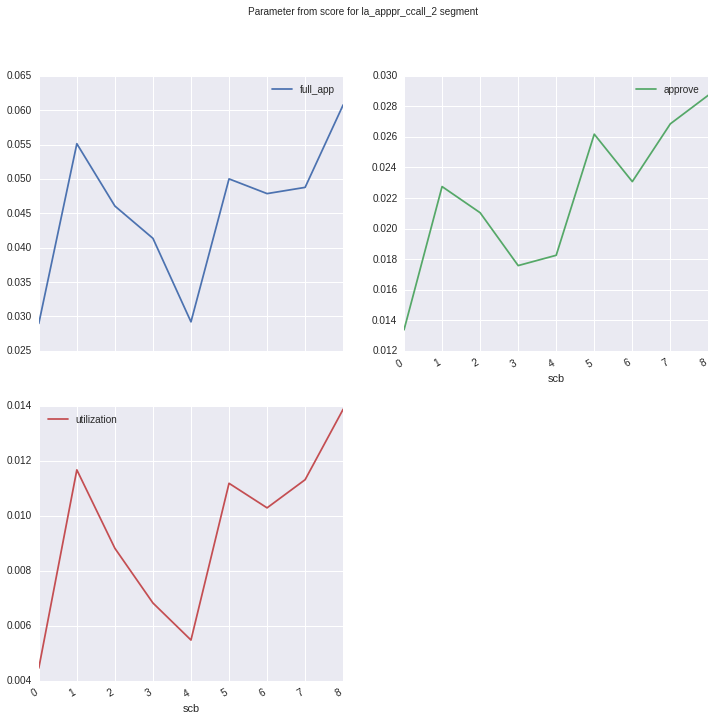

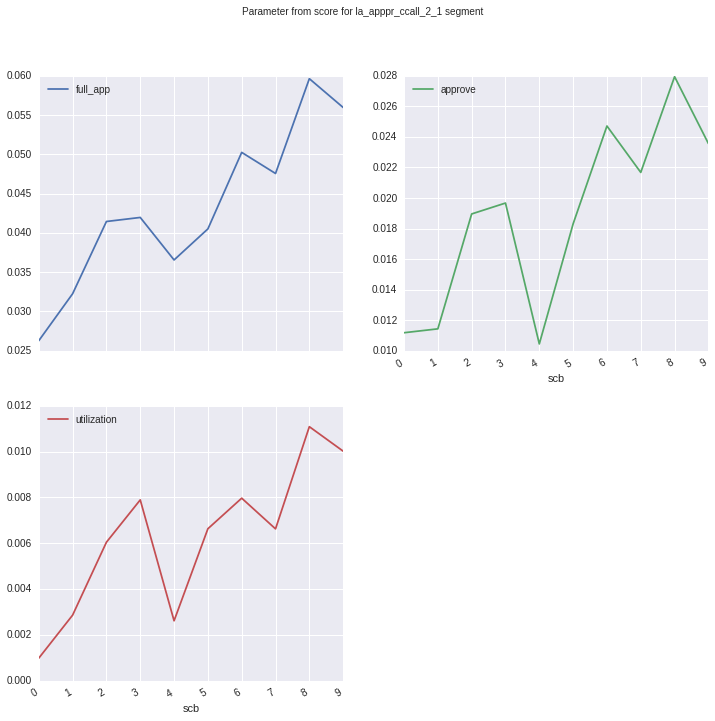

In [5]:
for segment_nm in df_prod['segment_nm'].unique():
    dfm = df_prod[(df_prod['segment_nm'] == segment_nm) & (df_prod['in_work'] == 0)]
    dfm.loc[:,'scb'] = pd.cut(dfm['score'], bins = np.unique(dfm['score'].quantile(np.arange(0,1.1,0.1)).values), labels  = False).values
    dfm.groupby('scb')['full_app','approve','utilization'].mean() \
          .plot(subplots = 1, layout = (2,2) , title  = 'Parameter from score for ' + segment_nm + ' segment', figsize = (12,12))
        #print('-' * 100)

In [6]:
for segment_nm in df_prod['segment_nm'].unique():
    idx = df_prod[(df_prod['segment_nm'] == segment_nm) & (df_prod['in_work'] == 0)].index
    df_prod.loc[idx,'scb'] = pd.cut(df_prod.loc[idx,'score'], bins = np.unique(df_prod.loc[idx,'score'].quantile(np.arange(0,1.2,0.2)).values), labels  = False).values

In [7]:
df1 = df_prod.query('in_work == 0')
df_res = pd.DataFrame(df1.groupby('scb')[['full_app','approve','utilization']].mean().values,columns = ['full_app','approve_from_all','util_from_all'])
#df1.groupby('scb')[['full_app','approve','utilization']].mean()
df_res.loc[:,'approve_from_full_app'] = df1.query('full_app == 1').groupby('scb')['approve'].mean()
df_res.loc[:,'util_from_approve'] = df1.query('approve == 1').groupby('scb')['utilization'].mean()
df_res

,full_app,approve_from_all,util_from_all,approve_from_full_app,util_from_approve
0,0.034520,0.014062,0.004406,0.407343,0.313305
1,0.042358,0.019282,0.007413,0.455208,0.384439
2,0.042281,0.020020,0.007589,0.473504,0.379061
3,0.048495,0.023355,0.009156,0.481600,0.392027
4,0.057919,0.026959,0.011443,0.465455,0.424479


### Зависимость от скора по тестовым сегментам

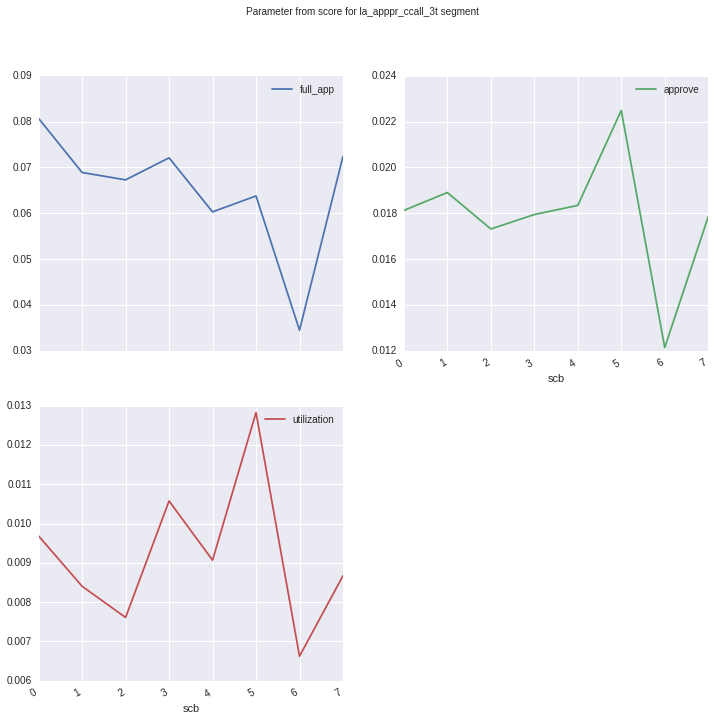

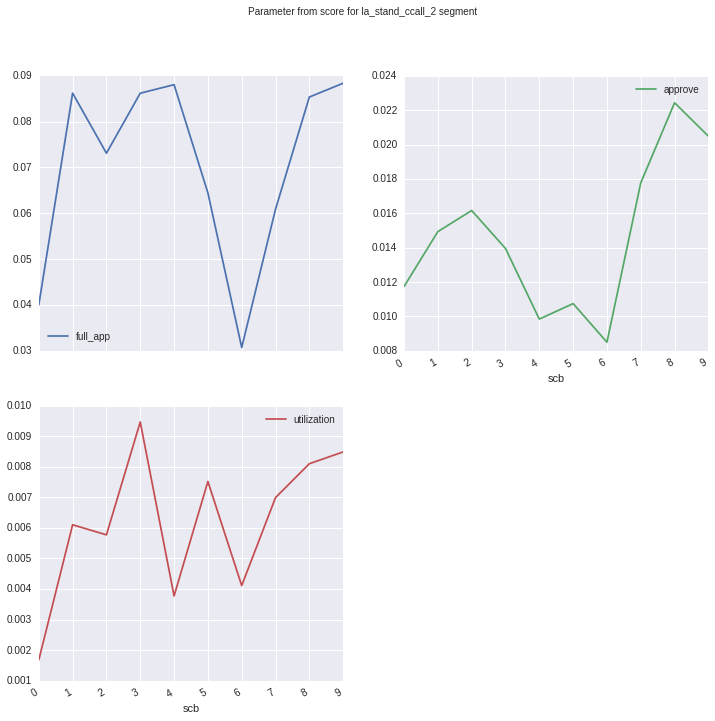

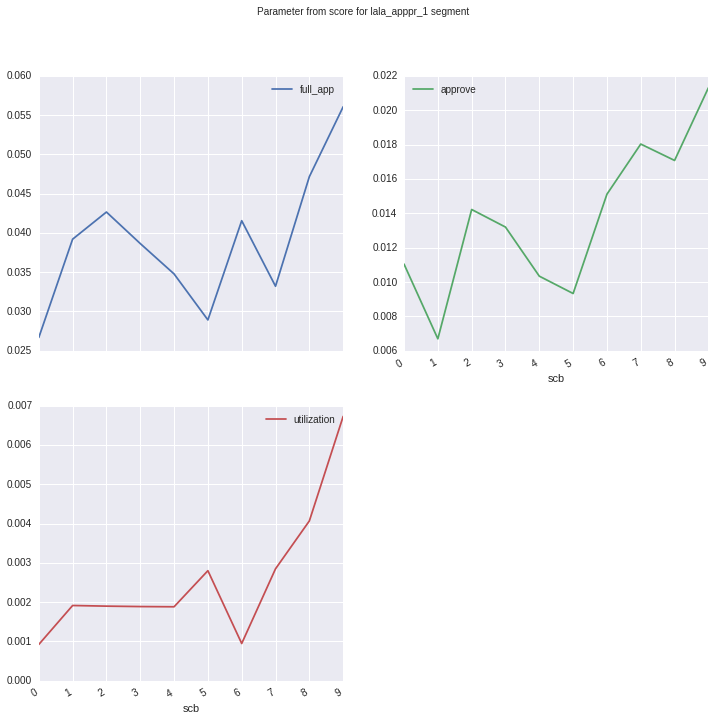

In [88]:
for segment_nm in df_test['segment_nm'].unique():
    dfm = df_test[(df_test['segment_nm'] == segment_nm) & (df_test['in_work'] == 0)]
    dfm.loc[:,'scb'] = pd.cut(dfm['score'], bins = np.unique(dfm['score'].quantile(np.arange(0,1.1,0.1)).values), labels  = False).values
    dfm.groupby('scb')['full_app','approve','utilization'].mean() \
          .plot(subplots = 1, layout = (2,2) , title  = 'Parameter from score for ' + segment_nm + ' segment', figsize = (12,12))
        #print('-' * 100)

In [89]:
for segment_nm in df_test['segment_nm'].unique():
    idx = df_test[(df_test['segment_nm'] == segment_nm) & (df_test['in_work'] == 0)].index
    df_test.loc[idx,'scb'] = pd.cut(df_test.loc[idx,'score'], bins = np.unique(df_test.loc[idx,'score'].quantile(np.arange(0,1.2,0.2)).values), labels  = False).values

df2 = df_test.query('in_work == 0')
df_res2 = pd.DataFrame(df2.groupby('scb')[['full_app','approve','utilization']].mean().values,columns = ['full_app','approve_from_all','util_from_all'])
#df1.groupby('scb')[['full_app','approve','utilization']].mean()
df_res2.loc[:,'approve_from_full_app'] = df2.query('full_app == 1').groupby('scb')['approve'].mean()
df_res2.loc[:,'cnt'] = df2.groupby('scb')['approve'].count()
df_res2.loc[:,'util_from_approve'] = df2.query('approve == 1').groupby('scb')['utilization'].mean()
df_res2

,full_app,approve_from_all,util_from_all,approve_from_full_app,cnt,util_from_approve
0,0.066910,0.015192,0.005955,0.227050,21327,0.391975
1,0.067768,0.016484,0.006879,0.243243,24569,0.417284
2,0.072440,0.011965,0.005535,0.165169,12286,0.462585
3,0.054546,0.017474,0.007935,0.320350,23063,0.454094
4,0.065074,0.017698,0.007556,0.271967,14691,0.426923


In [30]:
df_prod.groupby('ymd')['fll_app'].mean().plot()

call_ymd              2017-03-07
phone_mobile         89042384814
utm_campaign           cold_liru
segment_nm      la_apppr_ccall_2
in_work                        0
full_app                       0
considered                     0
approve                        0
utilization                    0
score                   -4.96888
seg_ymd               2017-03-04
scb                            1
Name: 0, dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e44097c50>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e43dc3dd0>]], dtype=object)

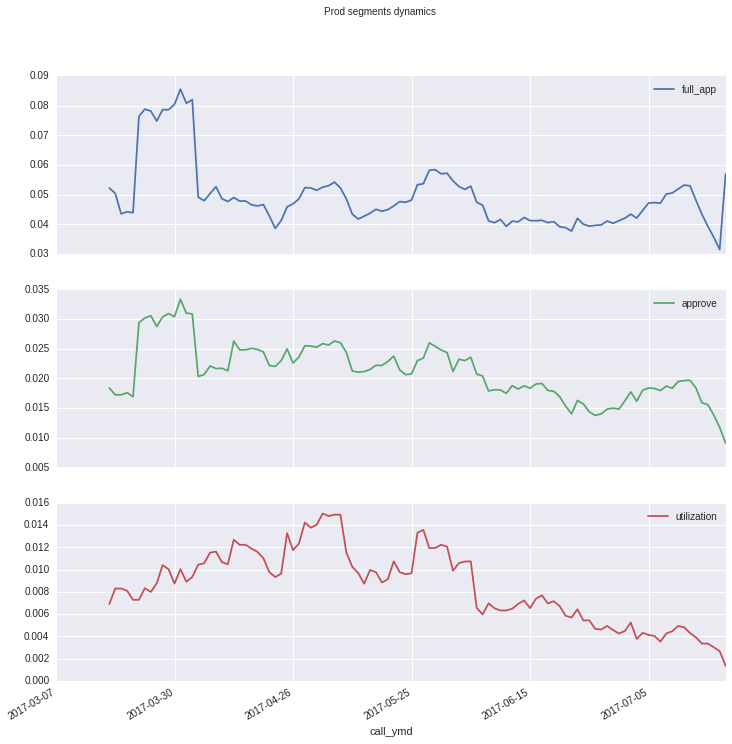

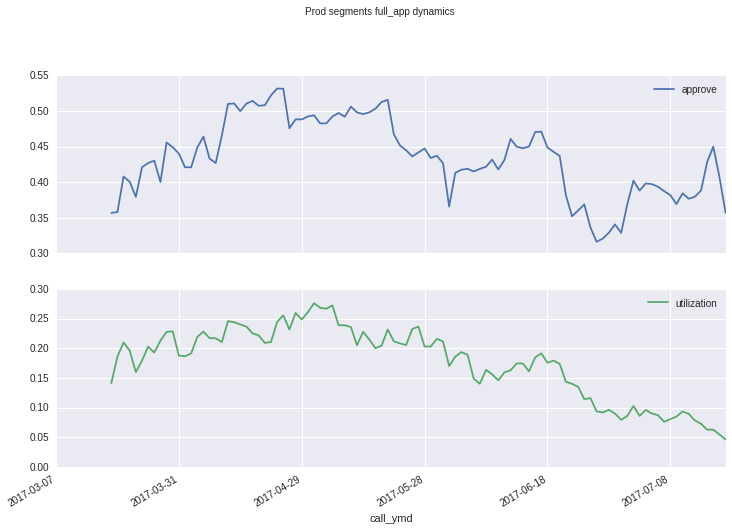

In [56]:
df_prod.groupby('call_ymd')['full_app','approve','utilization'].mean().rolling(window=10).mean() \
       .plot(subplots = 1, layout = (3,1), figsize = (12,12),title = 'Prod segments dynamics')
df_prod.query('full_app == 1').groupby('call_ymd')['approve','utilization'].mean().rolling(window=10).mean() \
       .plot(subplots = 1, layout = (3,1), figsize = (12,12),title = 'Prod segments full_app dynamics')

Test segments dynamics


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e45dc9190>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e42e85d10>]], dtype=object)

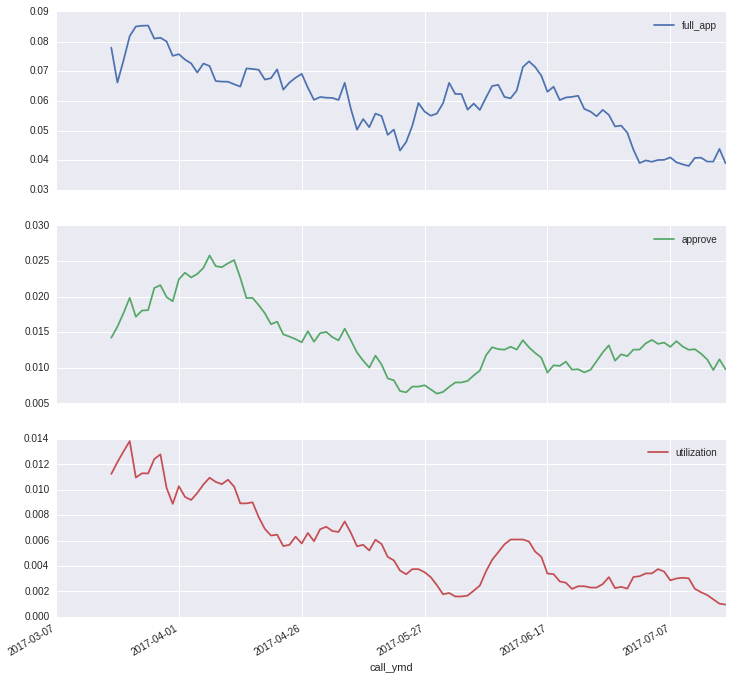

In [52]:
print('Test segments dynamics')
df_test.groupby('call_ymd')['full_app','approve','utilization'].mean().rolling(window=10).mean().plot(subplots = 1, layout = (3,1), figsize = (12,12))

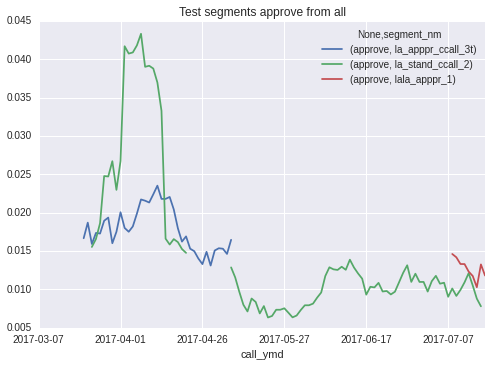

In [72]:
df_test.groupby(['call_ymd','segment_nm'])[['approve']].mean().unstack().rolling(window=10).mean().plot(title = 'Test segments approve from all')

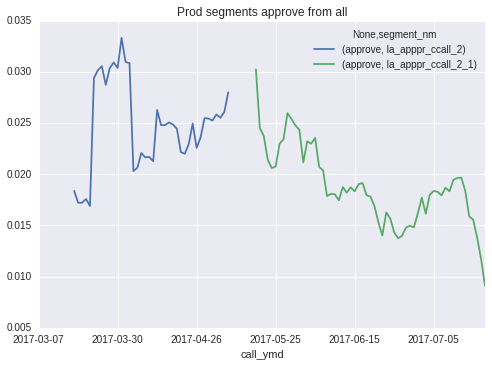

In [97]:
df_prod.groupby(['call_ymd','segment_nm'])[['approve']].mean().unstack().rolling(window=10).mean().plot(title = 'Prod segments approve from all')

### Эффективность снижается. Пробуем обновить коэффициенты

In [ ]:
query = '''


create table user_kposminin.urlfr_scores_check_20170803 as
with 
mymd_t as
 (
 select 
   max(ymd) as max_ymd
 from 
   prod_odd.url_fragment_target_cnt_cumulative
 where      
      ymd < date_add('2017-07-11',-3)
 )
  select 
    v.id, 
    max(if(u.id is Null,0,1)) as label, 
    max(t1.coeff) as score1, 
    max(t2.score) as score2,
    max(t3.score) as score3
   
  from
   (select id, url_fragment from prod_odd.visit_feature where ymd = '2017-07-11') v
   left join 
    (
      select id
      from prod_odd.user_action 
      where ymd between '2017-07-11' and date_add('2017-07-11',3)
      and action_type = 'tinkoff_platinum_approved_application'
    ) u on u.id = v.id
   left join dds_dic.max_coeff_url_fragment_score t1 on t1.url_fragment = v.url_fragment and t1.segment_nm = 'la_apppr_ccall_2_1'
   left join
    (
    select
      url_fragment,
      score['tinkoff_platinum_approved_application03_1m'] as score
    from
      mymd_t my      
      inner join prod_odd.url_fragment_target_cnt_cumulative t on t.ymd = my.max_ymd
    where
      (cnt_total > 100000 or cnt_positive['tinkoff_platinum_approved_application03_1m'] > 2)
    ) t2 on t2.url_fragment = v.url_fragment 
   left join
    (
    select
      url_fragment,
      score['tinkoff_platinum_approved_application03_1m'] as score
    from prod_features_liveinternet.url_fragment_target_cnt_cumulative t 
    where
      (cnt_total > 300000 or cnt_positive['tinkoff_platinum_approved_application03_1m'] > 10)
      and t.ymd = '2017-07-01'
    ) t3 on t3.url_fragment = v.url_fragment 
   group by
    v.id
;


with 
st1 as (select nvl(a.score1,-100) as score, a.label as label from user_kposminin.urlfr_scores_check_20170803 a),
st2 as (select nvl(a.score2,-100) as score, a.label as label from user_kposminin.urlfr_scores_check_20170803 a),
st3 as (select nvl(a.score3,-100) as score, a.label as label from user_kposminin.urlfr_scores_check_20170803 a),
cs1 as (
  select 
    (1-label) * sum(label) OVER (ORDER BY score DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as sl,
    label * avg(label) OVER (ORDER BY score DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as precision,
    label * log(1 + exp(-score)) + (1 - label) * log(1 + exp(score)) as logloss,
    label
  from st1),
cs2 as (
  select 
    (1-label) * sum(label) OVER (ORDER BY score DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as sl,
    label * avg(label) OVER (ORDER BY score DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as precision,
    label * log(1 + exp(-score)) + (1 - label) * log(1 + exp(score)) as logloss,
    label
  from st2),
cs3 as (
  select 
    (1-label) * sum(label) OVER (ORDER BY score DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as sl,
    label * avg(label) OVER (ORDER BY score DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as precision,
    label * log(1 + exp(-score)) + (1 - label) * log(1 + exp(score)) as logloss,
    label
  from st3)  
select 
  'Old coeffs' as name,
  '#ymd' as test_ymd,
  sum(sl)*1.0/((count(*)-max(sl))*max(sl)) as auc_roc,
  sum(precision)/sum(label) as auc_pr,
  avg(logloss) as logloss,
  sum(label)/count(*) as pos_share,
  count(*) as cnt
from cs1

union all

select 
  concat('New coeffs1 ', '') as name, 
  '#ymd' as test_ymd,
  sum(sl)*1.0/((count(*)-max(sl))*max(sl)) as auc_roc,
  sum(precision)/sum(label) as auc_pr,
  avg(logloss) as logloss,
  sum(label)/count(*) as pos_share,
  count(*) as cnt
from cs2 a 


union all

select 
  concat('New coeffs2 ', '') as name, 
  '#ymd' as test_ymd,
  sum(sl)*1.0/((count(*)-max(sl))*max(sl)) as auc_roc,
  sum(precision)/sum(label) as auc_pr,
  avg(logloss) as logloss,
  sum(label)/count(*) as pos_share,
  count(*) as cnt
from cs3 a 
;
'''

### Результаты:
    
 	_u1.name	_u1.auc_roc	_u1.auc_pr	_u1.logloss	_u1.pos_share	_u1.cnt
New coeffs1 - коэф за месяц	за июль 2017	0.85272954995638284	0.0041054161738371996	0.000343	2.31226-05	210789417

New coeffs2 - суммированные за месяц однодневные коэф за тот же период	0.84683482748699423	0.0041331295833685411	0.0003622655

Old coeffs- коэф текущей модели	0.83636896596449806	0.0024155795775473699	0.00037403484235757598	2.31226-05	210789417

### Обновленные месячные коэф за июль лучше всего. Обновляем модель la_apppr_ccall_2_1 (старые коэф ) => la_apppr_ccall_2_2 ( новые коэф )
### Так же в качестве тестового сегмента сделаем la_apppr_ccall_1_2 c суммированными за месяц однодневные коэф. за тот же период

In [4]:
df = hc.sql('select * from user_kposminin.urlfr_scores_check_20170803').toPandas()

Py4JJavaError: An error occurred while calling o125.collectToPython.
: org.apache.spark.SparkException: Job 1 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$cleanUpAfterSchedulerStop$1.apply(DAGScheduler.scala:808)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$cleanUpAfterSchedulerStop$1.apply(DAGScheduler.scala:806)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:78)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:806)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:1668)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:83)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:1587)
	at org.apache.spark.SparkContext$$anonfun$stop$8.apply$mcV$sp(SparkContext.scala:1833)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1283)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:1832)
	at org.apache.spark.scheduler.cluster.YarnClientSchedulerBackend$MonitorThread.run(YarnClientSchedulerBackend.scala:108)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1925)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1951)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1965)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:936)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:935)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:275)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply$mcI$sp(Dataset.scala:2768)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2765)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2765)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2788)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:2765)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
